In [254]:
import os, sklearn, math
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from joblib import dump, load

tf.random.set_seed(42)

data = '230802_Axial_z2_8Data'
dataname = data+'230803'+'_11'
filename = 'myData/'+data+'.csv'
SD1 = pd.read_csv(filename)
SD1=SD1.iloc[:,:13]
SensorData1 = SD1

In [255]:
SD1.sample(5)

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r
114764,35,33,44,33,39,53,58,60,49.63,0,76,0,7.2
179387,38,30,45,43,43,46,51,60,60.27,0,120,0,8.0
94868,38,32,51,51,49,49,60,62,5.07,0,64,0,1.6
159128,42,36,46,44,42,55,59,60,1.28,0,108,0,0.8
56914,35,41,55,44,45,51,62,58,10.70,0,38,0,2.4


In [256]:
SDreal = SD1

In [257]:
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r
count,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.0,235079.000000,235079.0,235079.000000
mean,37.855602,35.384769,47.421667,43.813399,45.391064,50.105960,60.760553,60.335164,28.366040,0.0,78.786263,0.0,4.397089
std,29.678911,77.255275,58.529797,71.599723,50.843784,71.695767,77.129128,50.722240,28.043329,0.0,46.194791,0.0,2.298731
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-483.760000,0.0,0.000000,0.0,0.800000
25%,36.000000,33.000000,45.000000,41.000000,44.000000,48.000000,59.000000,59.000000,11.960000,0.0,38.000000,0.0,2.400000
50%,38.000000,35.000000,47.000000,43.000000,46.000000,50.000000,60.000000,61.000000,29.310000,0.0,78.000000,0.0,4.000000
75%,40.000000,37.000000,49.000000,46.000000,47.000000,52.000000,62.000000,62.000000,43.440000,0.0,118.000000,0.0,6.400000
max,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,10001.950000,0.0,158.000000,0.0,8.000000


In [258]:
# SDreal 값이 0보다 작은데 encoder 인 것 제거
SDreal = SDreal[~((SDreal < 0)&(SDreal.columns != "encoder")).any(axis=1)]
#SDreal = SDreal[~((SDreal['z'] % 2 == 0) & (SDreal['z'] % 4 != 0))]

# SDreal 값이 100보다 크거나 0인데, 'theta', 'z', 'Force' 열이 아닌 것 제거
SDreal = SDreal[~(((SDreal >= 80)|(SDreal == 0) ) & 
                 (SDreal.columns != "theta") &
                 (SDreal.columns != "z") &
                 (SDreal.columns != "Force") &
                  (SDreal.columns != "encoder")).any(axis=1)]

# SDreal 값이 8191이거나 8190인 것 제거
SDreal = SDreal[~((SDreal == 8191) | (SDreal == 8190)).any(axis=1)]

# SDreal에서 결측값 제거
SDreal = SDreal[~SDreal.isna().any(axis=1)]

SDreal = SDreal[~((SDreal >= 800) & (SDreal.columns == "Force")).any(axis=1)]
SDreal = SDreal[~((SDreal <= -300) & (SDreal.columns == "Force")).any(axis=1)]

# k = 3
# for col in SDreal.columns:
#     mean = SDreal[col].mean()
#     std = SDreal[col].std()

#     outliers = (SDreal[col] < mean - k*std) | (SDreal[col] > mean + k*std)
#     SDreal = SDreal[~outliers]


SDreal = SDreal[SDreal["r"] >= 0.8*1]
SDreal = SDreal[SDreal["z"] <= 160]
SDreal = SDreal[SDreal["z"] >= 0]

SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r
count,221130.000000,221130.000000,221130.000000,221130.000000,221130.000000,221130.000000,221130.000000,221130.000000,221130.000000,221130.0,221130.000000,221130.0,221130.000000
mean,37.918650,34.784733,47.255709,43.392005,45.317103,49.743689,60.386827,60.420015,29.978973,0.0,81.171248,0.0,4.587745
std,2.984949,3.100398,3.106249,3.546644,3.205310,3.480590,2.907287,3.433605,16.961781,0.0,45.911363,0.0,2.203847
min,4.000000,3.000000,16.000000,10.000000,3.000000,6.000000,4.000000,5.000000,0.000000,0.0,0.000000,0.0,0.800000
25%,36.000000,33.000000,45.000000,41.000000,44.000000,48.000000,59.000000,59.000000,15.410000,0.0,42.000000,0.0,2.400000
50%,38.000000,35.000000,47.000000,43.000000,46.000000,50.000000,60.000000,61.000000,30.980000,0.0,82.000000,0.0,4.800000
75%,40.000000,37.000000,49.000000,46.000000,47.000000,52.000000,62.000000,62.000000,44.100000,0.0,120.000000,0.0,6.400000
max,72.000000,71.000000,74.000000,68.000000,77.000000,75.000000,76.000000,75.000000,68.550000,0.0,158.000000,0.0,8.000000


In [259]:
def apply_transformation(df, columns, transformation):
    # columns가 제공되지 않았다면 df의 모든 칼럼을 대상으로 함
    if columns is None:
        columns = df.columns

    for column in columns:
        df[column] = transformation(df[column])
    
    return df

def normalize(column):
    return (column - column.min()) / (column.max() - column.min())

def standardize(column):
    return (column - column.mean()) / column.std()

def submean(column):
    return (column - column.mean())



SDreal = apply_transformation(SDreal.copy(), ['r', 'Force', 'z'], normalize)
#SDreal = apply_transformation(SDreal.copy(), ['Sx00','Sx01','Sx02','Sx03','Sx04','Sx05','Sx06','Sx07'], submean)

#SDreal = apply_transformation(SDreal.copy(), ['r', 'Force', 'z'], submean)
#SDreal = apply_transformation(SDreal.copy(), ['Sx00','Sx01','Sx02','Sx03','Sx04','Sx05','Sx06','Sx07'], standardize)

SDreal

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r
591,37,33,43,41,45,51,63,58,0.019548,0,0.0,0,0.222222
592,37,33,43,41,47,51,63,58,0.019840,0,0.0,0,0.222222
593,37,35,45,41,47,51,66,58,0.021007,0,0.0,0,0.222222
594,37,35,45,41,47,51,66,58,0.019694,0,0.0,0,0.222222
595,37,35,45,41,47,49,66,58,0.018381,0,0.0,0,0.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235074,42,35,45,43,44,49,62,60,0.649307,0,1.0,0,1.000000
235075,41,35,45,41,44,49,60,60,0.649015,0,1.0,0,1.000000
235076,41,35,47,41,44,49,60,60,0.650182,0,1.0,0,1.000000
235077,43,35,47,40,45,49,60,60,0.650328,0,1.0,0,1.000000


In [260]:
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r
count,221130.000000,221130.000000,221130.000000,221130.000000,221130.000000,221130.000000,221130.000000,221130.000000,221130.000000,221130.0,221130.000000,221130.0,221130.000000
mean,37.918650,34.784733,47.255709,43.392005,45.317103,49.743689,60.386827,60.420015,0.437330,0.0,0.513742,0.0,0.526076
std,2.984949,3.100398,3.106249,3.546644,3.205310,3.480590,2.907287,3.433605,0.247437,0.0,0.290578,0.0,0.306090
min,4.000000,3.000000,16.000000,10.000000,3.000000,6.000000,4.000000,5.000000,0.000000,0.0,0.000000,0.0,0.000000
25%,36.000000,33.000000,45.000000,41.000000,44.000000,48.000000,59.000000,59.000000,0.224799,0.0,0.265823,0.0,0.222222
50%,38.000000,35.000000,47.000000,43.000000,46.000000,50.000000,60.000000,61.000000,0.451933,0.0,0.518987,0.0,0.555556
75%,40.000000,37.000000,49.000000,46.000000,47.000000,52.000000,62.000000,62.000000,0.643326,0.0,0.759494,0.0,0.777778
max,72.000000,71.000000,74.000000,68.000000,77.000000,75.000000,76.000000,75.000000,1.000000,0.0,1.000000,0.0,1.000000


In [261]:
SDy = SDreal.iloc[:,[8,10]]
SDy.describe()

,Force,z
count,221130.000000,221130.000000
mean,0.437330,0.513742
std,0.247437,0.290578
min,0.000000,0.000000
25%,0.224799,0.265823
50%,0.451933,0.518987
75%,0.643326,0.759494
max,1.000000,1.000000


In [262]:
X = SDreal.iloc[:,0:8]
y = SDreal.iloc[:,[8,10]]

In [263]:
X

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07
591,37,33,43,41,45,51,63,58
592,37,33,43,41,47,51,63,58
593,37,35,45,41,47,51,66,58
594,37,35,45,41,47,51,66,58
595,37,35,45,41,47,49,66,58
...,...,...,...,...,...,...,...,...
235074,42,35,45,43,44,49,62,60
235075,41,35,45,41,44,49,60,60
235076,41,35,47,41,44,49,60,60
235077,43,35,47,40,45,49,60,60


In [264]:
y.sample(5)

,Force,z
163837,0.619548,0.696203
197644,0.185850,0.848101
156020,0.839387,0.658228
232788,0.159008,1.000000
60721,0.440700,0.253165


In [265]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.01, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state=42)

In [266]:
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)

print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  175134 ea 79 %    X_valid:  43784 ea 19 %    X_test:  2212 ea 1 %


In [267]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [268]:
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_SS.pkl'
dump(scaler, file_name)

['myScaler/230802_Axial_z2_8Data230803_11_SS.pkl']

In [269]:
from tensorflow import keras
model = keras.models.Sequential([   
    keras.layers.Dense(64, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),            
    keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),            
    keras.layers.Dense(16, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(8, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(2)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 64)                576       
                                                                 
 dense_48 (Dense)            (None, 32)                2080      
                                                                 
 dense_49 (Dense)            (None, 16)                528       
                                                                 
 dense_50 (Dense)            (None, 8)                 136       
                                                                 
 dense_51 (Dense)            (None, 2)                 18        
                                                                 
Total params: 3,338
Trainable params: 3,338
Non-trainable params: 0
_________________________________________________________________


## Callback (best, early stopping, tensorboard)

In [270]:
import os 
#root_logdir = os.path.join(os.curdir, 'mylog/'+data)
root_logdir = os.path.join(os.curdir, 'mylog/'+'230320_Data')

def get_run_logdir():
    import time
    run_id= time.strftime("%m%d_%Hh%Mm%Ss"+dataname)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [271]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [272]:
dataname

'230802_Axial_z2_8Data230803_11'

In [273]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
n_epochs = 300
batch_size = 4
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle,early_stopping_cb,tensorboard_cb])
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:5]
y_pred = model.predict(X_new)

Epoch 1/300
5473/5473 [==============================] - 8s 1ms/step - loss: 0.0283 - val_loss: 0.0260
Epoch 2/300
5473/5473 [==============================] - 7s 1ms/step - loss: 0.0257 - val_loss: 0.0249
Epoch 3/300
5473/5473 [==============================] - 8s 1ms/step - loss: 0.0252 - val_loss: 0.0249
Epoch 4/300
5473/5473 [==============================] - 7s 1ms/step - loss: 0.0250 - val_loss: 0.0246
Epoch 5/300
5473/5473 [==============================] - 7s 1ms/step - loss: 0.0249 - val_loss: 0.0257
Epoch 6/300
5473/5473 [==============================] - 7s 1ms/step - loss: 0.0248 - val_loss: 0.0258
Epoch 7/300
5473/5473 [==============================] - 7s 1ms/step - loss: 0.0246 - val_loss: 0.0246
Epoch 8/300
5473/5473 [==============================] - 7s 1ms/step - loss: 0.0245 - val_loss: 0.0244
Epoch 9/300
5473/5473 [==============================] - 8s 1ms/step - loss: 0.0245 - val_loss: 0.0251
Epoch 10/300
5473/5473 [==============================] - 9s 2ms/step - l

In [274]:
# %load_ext tensorboard
# %tensorboard --logdir=./mylog/230320_Data --port=2322

In [275]:
model.save('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/TACTS/TACTS_v1/myModel/'+dataname+'.h5')

In [276]:
model = tf.keras.models.load_model('myModel/'+dataname+'.h5')
scaler = load(file_name)
valid_predictions = model.predict(X_valid)

valid_predictions_df=pd.DataFrame(valid_predictions)
valid_predictions_df.columns = ["valid_force","valid_z"]
#valid_predictions_df.columns = ["valid_force","valid_z","valid_r"]
valid_predictions_df

k= y_valid.to_numpy()
k_df = pd.DataFrame(k)
#k_df.columns  = ["force","z","r"]
k_df.columns  = ["force","z"]
k_df.describe()

1369/1369 [==============================] - 1s 905us/step


,force,z
count,43784.000000,43784.000000
mean,0.438299,0.512736
std,0.245966,0.290480
min,0.000000,0.000000
25%,0.231510,0.265823
50%,0.453246,0.518987
75%,0.642743,0.759494
max,0.990664,1.000000


In [277]:
ValidPre = pd.concat( [k_df,valid_predictions_df],axis=1)
ValidPre.head(5)
corr = ValidPre.corr()
print("corr")
n = k_df.shape[1]
for i in range(0,n):    
    print(format(corr[valid_predictions_df.columns[i]][k_df.columns[i]]*100,'.2f')+'%',k_df.columns[i])
corr

corr
82.14% force
81.45% z


,force,z,valid_force,valid_z
force,1.000000,0.120185,0.821374,0.206000
z,0.120185,1.000000,0.155103,0.814533
valid_force,0.821374,0.155103,1.000000,0.206913
valid_z,0.206000,0.814533,0.206913,1.000000


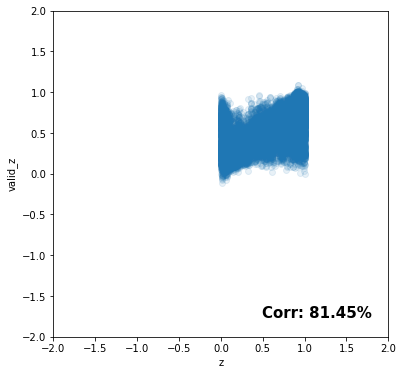

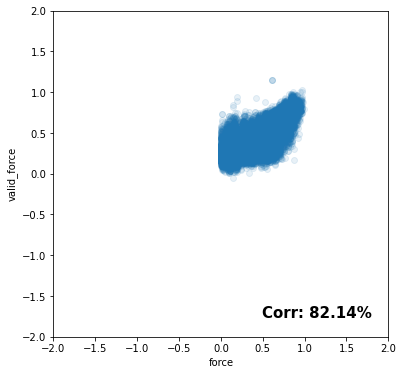

In [278]:
import pandas as pd
import os
import matplotlib.pyplot as plt

alpa = 0.1
output_dir = "myLearningData/savefig"  # 저장할 폴더 이름

# 폴더가 없는 경우 폴더를 생성합니다.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

fields = ['z', 'force']

for field in fields:
    plt.figure(figsize=(6, 6))  # Set the figure size to 1:1
    plt.scatter(ValidPre[field], ValidPre[f"valid_{field}"], alpha=alpa)
    plt.xlabel(field)
    plt.ylabel(f"valid_{field}")
    plt.xlim(-2, 2)  # x축 범위 설정
    plt.ylim(-2, 2)  # y축 범위 설정

    # Compute the correlation value to be added
    corr_value = format(corr[f"valid_{field}"][field]*100,'.2f') + '%'
    plt.text(0.95, 0.05, f'Corr: {corr_value}', ha='right', va='bottom', 
             transform=plt.gca().transAxes, fontsize=15, weight='bold')

    plt.savefig(os.path.join(output_dir, f"{dataname}_{field}.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장
    plt.show()
